In [1]:
import pyvista as pv
from ansys.mapdl.reader import save_as_archive
from ansys.mapdl.core import launch_mapdl
import gmsh
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sps

gmsh.initialize()

In [57]:
import gmsh
import matplotlib.pyplot as plt

import numpy as np
import sys
import gmsh


def triangle_max_edge(x):
    a = np.sum((x[:, 0, :] - x[:, 1, :]) ** 2, 1) ** 0.5
    b = np.sum((x[:, 0, :] - x[:, 2, :]) ** 2, 1) ** 0.5
    c = np.sum((x[:, 1, :] - x[:, 2, :]) ** 2, 1) ** 0.5
    return np.maximum(a, np.maximum(b, c))


class Mesh:
    def __init__(self):
        self.vtags, vxyz, _ = gmsh.model.mesh.getNodes()
        self.vxyz = vxyz.reshape((-1, 3))
        vmap = dict({j: i for i, j in enumerate(self.vtags)})
        self.triangles_tags, evtags = gmsh.model.mesh.getElementsByType(2)
        evid = np.array([vmap[j] for j in evtags])
        self.triangles = evid.reshape((self.triangles_tags.shape[-1], -1))


# def my_function(xyz):
#     a = 6 * (np.hypot(xyz[..., 0] - 0.5, xyz[..., 1] - 0.5) - 0.2)
#     f = np.real(np.arctanh(a + 0j))
#     return f


def my_function(xyz):
    a = np.hypot(xyz[..., 0] - 0.5, xyz[..., 1] - 0.5)
    return np.exp(-a / 0.2)


def compute_interpolation_error(nodes, triangles, f):
    uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
    jac, det, pt = gmsh.model.mesh.getJacobians(2, uvw)
    numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
    sf = sf.reshape((weights.shape[0], -1))
    qx = pt.reshape((triangles.shape[0], -1, 3))
    det = np.abs(det.reshape((triangles.shape[0], -1)))
    f_vert = f(nodes)
    f_fem = np.dot(f_vert[triangles], sf)
    err_tri = np.sum((f_fem - f(qx)) ** 2 * det * weights, 1)
    return f_vert, np.sqrt(err_tri)


def compute_size_field(nodes, triangles, err, N):
    x = nodes[triangles]
    a = 2.0
    d = 2.0
    fact = (a ** ((2.0 + a) / (1.0 + a)) + a ** (1.0 / (1.0 + a))) * np.sum(
        err ** (2.0 / (1.0 + a))
    )
    ri = (
        err ** (2.0 / (2.0 * (1 + a)))
        * a ** (1.0 / (d * (1.0 + a)))
        * ((1.0 + a) * N / fact) ** (1.0 / d)
    )
    return triangle_max_edge(x) / ri


gmsh.initialize()
gmsh.clear()

lc = 0.01

gmsh.model.add("square")
square = gmsh.model.occ.addRectangle(
    0, 0, 0, 1, 1
)  ## Adding a square to the domain and return the tag of the square

gmsh.model.occ.synchronize()
pnts = gmsh.model.getBoundary(
    [(2, square)], True, True, True
)  ## Square is of dimension 2 and we get it's boundary using the tag
# print(pnts)
gmsh.model.addPhysicalGroup(1, np.array(pnts)[:, 1], 11)
gmsh.model.setPhysicalName(1, 11, "Boundary")

gmsh.model.addPhysicalGroup(2, [square], 1)
gmsh.model.setPhysicalName(2, 1, "Domain")

gmsh.model.mesh.setSize(pnts, lc)  ## Setting the size of the points
gmsh.model.mesh.generate(2)


nodeTags, coord, param = gmsh.model.mesh.getNodes()
elementTags, nodeTagsTriangles = gmsh.model.mesh.getElementsByType(2)

# plt.figure(figsize=(10, 10))
# plt.triplot(
#     coord.reshape(-1, 3)[:, 0],
#     coord.reshape(-1, 3)[:, 1],
#     nodeTagsTriangles.reshape(-1, 3) - 1,
# )

# plt.show()
# vmap = dict({j: i for i, j in enumerate(nodeTags)})
# evid = np.array([vmap[j] for j in nodeTagsTriangles])
# triangles = evid.reshape((elementTags.shape[-1], -1))

# f_vert, err = compute_interpolation_error(coord.reshape(-1, 3), triangles, my_function)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000145959s, CPU 0.000198s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.196835s, CPU 0.194648s)
Info    : 11820 nodes 23642 elements


In [58]:
def f(xy):
    return np.ones((xy.shape[0],))

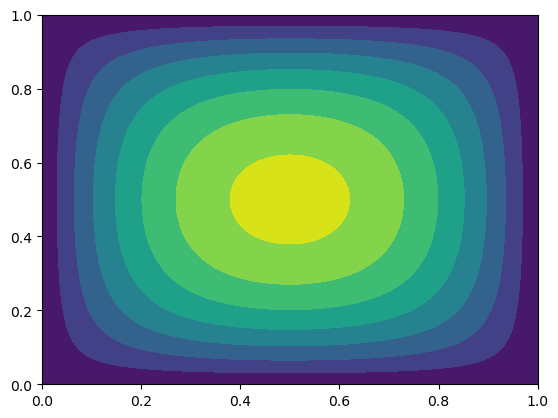

In [59]:
nodeTags, coords, _ = gmsh.model.mesh.getNodes()
nodeTypes = np.ones((np.max(np.array(nodeTags)) + 1,), dtype=np.int32)
nodeTypes[0] = 0
numMeshNodes = len(nodeTags)
grps = gmsh.model.getPhysicalGroups()
coords = coords.reshape(-1, 3)
matrowflat = np.array([], dtype=np.int32)
matcolflat = np.array([], dtype=np.int32)
matflat = np.array([])
rhsrowflat = np.array([], dtype=np.int32)
rhsflat = np.array([])
maxNodeTag = int(np.amax(nodeTags))


for grpDim, grpTag in grps:
    grp_name = gmsh.model.getPhysicalName(grpDim, grpTag)
    if grp_name == "Boundary":  ### Identify the boundary
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                nodeTypes[nodeTags] = 2
    if grp_name == "Domain":  ### Setup the stiffness matrix for 1-D
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                numElements = len(elementTags)
                numGroupNodes = len(nodeTags)
                enode = np.array(nodeTags, dtype=np.int32).reshape((numElements, -1))
                numElementNodes = enode.shape[1]

                prop = gmsh.model.mesh.getElementProperties(2)
                uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
                numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
                weights = np.array(weights)
                numGaussPoints = len(weights)
                sf = np.array(sf).reshape((numGaussPoints, -1))
                numcomp, dsfdu, _ = gmsh.model.mesh.getBasisFunctions(
                    2, uvw, "GradLagrange"
                )
                dsfdu = np.array(dsfdu).reshape((numGaussPoints, 3, 3))[:, :, :-1]
                qjac, qdet, qpoint = gmsh.model.mesh.getJacobians(2, uvw, 1)
                qdet = np.array(qdet).reshape((numElements, numGaussPoints))
                dxdu = np.array(qjac).reshape((numElements, numGaussPoints, 3, 3))[
                    :, :, :-1, :-1
                ]
                # jacobian stored by row, so dxdu[i][j] = dxdu_ij = dxi/duj

                # dudx[j][k] = dudx_jk = duj/dxk
                dudx = np.linalg.inv(dxdu)
                dsfdx = np.einsum("egxu,gnu->egnx", dudx, dsfdu)
                localmat = np.einsum("egik,egjk,eg,g->eij", dsfdx, dsfdx, qdet, weights)
                matcol = np.repeat(enode[:, :, None], numElementNodes, axis=2)
                matrow = np.repeat(enode[:, None, :], numElementNodes, axis=1)

                matcolflat = np.append(matcolflat, matcol.flatten())
                matrowflat = np.append(matrowflat, matrow.flatten())
                matflat = np.append(matflat, localmat.flatten())
                localrhs = np.einsum(
                    "gn,eg,g,g->en", sf, qdet, weights, f(uvw.reshape(-1, 3)[:, :-1])
                )
                rhsrowflat = np.append(rhsrowflat, enode.flatten())
                rhsflat = np.append(rhsflat, localrhs.flatten())

node2unknown = np.zeros(maxNodeTag + 1, dtype=np.int32)

index = 0
for tagNode, typ in enumerate(nodeTypes):
    if typ == 1:  # not fixed
        index += 1
        node2unknown[tagNode] = index
numUnknowns = index
for tagNode, typ in enumerate(nodeTypes):
    if typ == 2:  # fixed
        index += 1
        node2unknown[tagNode] = index
if index != numMeshNodes:
    print("Something went wrong")


unknown2node = np.zeros(numMeshNodes + 1, dtype=np.int32)
for node, unkn in enumerate(node2unknown):
    unknown2node[unkn] = node


globalmat = sps.coo_matrix(
    (matflat, (node2unknown[matcolflat] - 1, node2unknown[matrowflat] - 1)),
    shape=(numMeshNodes, numMeshNodes),
).tocsr()

globalrhs = np.zeros(numMeshNodes)
for index, node in enumerate(rhsrowflat):
    globalrhs[node2unknown[node] - 1] += rhsflat[index]

sol = sps.linalg.spsolve(globalmat[:numUnknowns, :numUnknowns], globalrhs[:numUnknowns])
sol = np.append(sol, np.zeros(numMeshNodes - numUnknowns))


plt.tricontourf(
    coords.reshape(-1, 3)[:, 0], coords.reshape(-1, 3)[:, 1], sol[node2unknown[1:] - 1]
)
plt.show()

In [ ]:
import numpy as np
import sys
import gmsh


def triangle_max_edge(x):
    a = np.sum((x[:, 0, :] - x[:, 1, :]) ** 2, 1) ** 0.5
    b = np.sum((x[:, 0, :] - x[:, 2, :]) ** 2, 1) ** 0.5
    c = np.sum((x[:, 1, :] - x[:, 2, :]) ** 2, 1) ** 0.5
    return np.maximum(a, np.maximum(b, c))


class Mesh:
    def __init__(self):
        self.vtags, vxyz, _ = gmsh.model.mesh.getNodes()
        self.vxyz = vxyz.reshape((-1, 3))
        vmap = dict({j: i for i, j in enumerate(self.vtags)})
        self.triangles_tags, evtags = gmsh.model.mesh.getElementsByType(2)
        evid = np.array([vmap[j] for j in evtags])
        self.triangles = evid.reshape((self.triangles_tags.shape[-1], -1))


def my_function(xyz):
    a = 6 * (np.hypot(xyz[..., 0] - 0.5, xyz[..., 1] - 0.5) - 0.2)
    f = np.real(np.arctanh(a + 0j))
    return f


def compute_interpolation_error(nodes, triangles, f):
    uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
    jac, det, pt = gmsh.model.mesh.getJacobians(2, uvw)
    numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
    sf = sf.reshape((weights.shape[0], -1))
    qx = pt.reshape((triangles.shape[0], -1, 3))
    det = np.abs(det.reshape((triangles.shape[0], -1)))
    f_vert = f(nodes)
    f_fem = np.dot(f_vert[triangles], sf)
    err_tri = np.sum((f_fem - f(qx)) ** 2 * det * weights, 1)
    return f_vert, np.sqrt(err_tri)


def compute_size_field(nodes, triangles, err, N):
    x = nodes[triangles]
    a = 2.0
    d = 2.0
    fact = (a ** ((2.0 + a) / (1.0 + a)) + a ** (1.0 / (1.0 + a))) * np.sum(
        err ** (2.0 / (1.0 + a))
    )
    ri = (
        err ** (2.0 / (2.0 * (1 + a)))
        * a ** (1.0 / (d * (1.0 + a)))
        * ((1.0 + a) * N / fact) ** (1.0 / d)
    )
    return triangle_max_edge(x) / ri


print("Usage: adapt_mesh [initial lc] [target #elements] [dump files]")

lc = 0.02
N = 10000
dumpfiles = False
gui = True

argv = sys.argv
if "-nopopup" in sys.argv:
    gui = False
    argv.remove("-nopopup")

if len(argv) > 1:
    lc = 0.1
if len(argv) > 2:
    N = 10
if len(argv) > 3:
    dumpfiles = 3
gmsh.initialize()

# create a geometrical gmsh.model
gmsh.model.add("square")
square = gmsh.model.occ.addRectangle(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()

# create intial uniform mesh
pnts = gmsh.model.getBoundary([(2, square)], True, True, True)
gmsh.model.mesh.setSize(pnts, lc)
# gmsh.option.setNumber('Mesh.Algorithm', 6) # Frontal
gmsh.model.mesh.generate(2)
if dumpfiles:
    gmsh.write("mesh.msh")
mesh = Mesh()

# compute and visualize the interpolation error
f_nod, err_ele = compute_interpolation_error(mesh.vxyz, mesh.triangles, my_function)
f_view = gmsh.view.add("nodal function")
gmsh.view.addModelData(f_view, 0, "square", "NodeData", mesh.vtags, f_nod[:, None])
if dumpfiles:
    gmsh.view.write(f_view, "f.pos")
err_view = gmsh.view.add("element-wise error")
gmsh.view.addModelData(
    err_view, 0, "square", "ElementData", mesh.triangles_tags, err_ele[:, None]
)
if dumpfiles:
    gmsh.view.write(err_view, "err.pos")

# compute and visualize the remeshing size field
sf_ele = compute_size_field(mesh.vxyz, mesh.triangles, err_ele, N)
sf_view = gmsh.view.add("mesh size field")
gmsh.view.addModelData(
    sf_view, 0, "square", "ElementData", mesh.triangles_tags, sf_ele[:, None]
)
gmsh.plugin.setNumber("Smooth", "View", gmsh.view.getIndex(sf_view))
gmsh.plugin.run("Smooth")
if dumpfiles:
    gmsh.view.write(sf_view, "sf.pos")

# create a new gmsh.model (to remesh the original gmsh.model in-place, the size field
# should be created as a list-based view)
gmsh.model.add("square2")
gmsh.model.occ.addRectangle(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()

# mesh the new gmsh.model using the size field
bg_field = gmsh.model.mesh.field.add("PostView")
gmsh.model.mesh.field.setNumber(bg_field, "ViewTag", sf_view)
gmsh.model.mesh.field.setAsBackgroundMesh(bg_field)
# gmsh.option.setNumber('Mesh.Algorithm', 2) # Delaunay
gmsh.model.mesh.generate(2)
if dumpfiles:
    gmsh.write("mesh2.msh")
mesh2 = Mesh()

# compute and visualize the interpolation error on the adapted mesh
f2_nod, err2_ele = compute_interpolation_error(mesh2.vxyz, mesh2.triangles, my_function)
f2_view = gmsh.view.add("nodal function on adapted mesh")
gmsh.view.addModelData(f2_view, 0, "square2", "NodeData", mesh2.vtags, f2_nod[:, None])
if dumpfiles:
    gmsh.view.write(f2_view, "f2.pos")
err2_view = gmsh.view.add("element-wise error on adapated mesh")
gmsh.view.addModelData(
    err2_view, 0, "square2", "ElementData", mesh2.triangles_tags, err2_ele[:, None]
)
if dumpfiles:
    gmsh.view.write(err2_view, "err2.pos")

# show everything in the gui
if gui:
    gmsh.fltk.run()

gmsh.finalize()

Usage: adapt_mesh [initial lc] [target #elements] [dump files]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 9.7e-05s, CPU 0.000129s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0028275s, CPU 0.002827s)
Info    : 143 nodes 288 elements
Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00628463s, CPU 0.006251s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0456559s, CPU 0.045156s)
Info    : 3335 nodes 6672 elements
------------------------------------

In [13]:
import gmsh
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import sys

# This scripts solves the 2D Poisson equation '-\Delta u = f' with homogeneous
# boundary conditions using the finite element method.

# Simply run the script with
# $ python examples/api/poisson.py
# with usual gmsh line arguments, e.g., -clscale 0.5 -order 2

DEBUG = 1
RECOMBINE = 0


def debug(*args):
    if not DEBUG:
        return
    if sys.version_info.major == 3:
        exec("print( *args )")
    else:
        for item in args:
            exec("print item,")
        exec("print")


def error(argv):
    debug(argv)
    exit(1)


def create_geometry():
    gmsh.model.add("poisson")
    surf = []
    surf.append((2, gmsh.model.occ.addRectangle(0, 0, 0, 1, 1)))
    surf.append((2, gmsh.model.occ.addDisk(0.7, 0.5, 0, 0.1, 0.1)))
    surf.append((2, gmsh.model.occ.addRectangle(0.2, 0.4, 0, 0.2, 0.2)))
    surf, _ = gmsh.model.occ.fragment(surf, [])
    gmsh.model.occ.synchronize()

    bnd = gmsh.model.getBoundary(surf, combined=True, oriented=False, recursive=False)
    bnd = np.array(bnd)

    gmsh.model.addPhysicalGroup(2, [surf[0][1]], 2)
    gmsh.model.setPhysicalName(2, 2, "SourceCircle")
    gmsh.model.addPhysicalGroup(2, [surf[1][1]], 3)
    gmsh.model.setPhysicalName(2, 3, "SourceSquare")
    gmsh.model.addPhysicalGroup(2, [surf[2][1]], 4)
    gmsh.model.setPhysicalName(2, 4, "Domain")
    gmsh.model.addPhysicalGroup(1, bnd[:, 1], 11)
    gmsh.model.setPhysicalName(1, 11, "Boundary")

    gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 1.0)
    return


def fem_solve():
    mshNodes = np.array(gmsh.model.mesh.getNodes()[0])
    numMeshNodes = len(mshNodes)
    maxNodeTag = int(np.amax(mshNodes))
    debug("numMeshNodes =", numMeshNodes, " maxNodeTag =", maxNodeTag)

    # typNodes[tag] = {0:does not exist, 1:internal node, 2:boundary node}
    # Existing node tags are defined here. Boundary node tag are identified later.
    typNodes = np.zeros(maxNodeTag + 1, dtype=np.int32)
    for tagNode in mshNodes:
        typNodes[tagNode] = 1

    # initializations of global assembly arrays iteratively filled-in during
    # assembly
    matrowflat = np.array([], dtype=np.int32)
    matcolflat = np.array([], dtype=np.int32)
    matflat = np.array([], dtype=np.int32)
    rhsrowflat = np.array([], dtype=np.int32)
    rhsflat = np.array([], dtype=np.int32)

    # The read-in mesh is iterated over, looping successively (nested loops) over:
    # Physical groups/Geometrical entities/Element types/Elements
    vGroups = gmsh.model.getPhysicalGroups()
    for iGroup in vGroups:
        dimGroup = iGroup[0]  # 1D, 2D or 3D
        tagGroup = iGroup[1]
        namGroup = gmsh.model.getPhysicalName(dimGroup, tagGroup)
        vEntities = gmsh.model.getEntitiesForPhysicalGroup(dimGroup, tagGroup)
        for tagEntity in vEntities:
            # FIXME dimEntity should be optional when tagEntity given
            dimEntity = dimGroup
            vElementTypes = gmsh.model.mesh.getElementTypes(dimEntity, tagEntity)
            for elementType in vElementTypes:
                vTags, vNodes = gmsh.model.mesh.getElementsByType(
                    elementType, tagEntity
                )
                numElements = len(vTags)
                numGroupNodes = len(vNodes)
                enode = np.array(vNodes, dtype=np.int32).reshape((numElements, -1))
                numElementNodes = enode.shape[1]
                debug(
                    "\nIn group",
                    namGroup,
                    " with tag ",
                    tagGroup,
                    ", numElements = e =",
                    numElements,
                )
                debug(
                    "numGroupNodes =",
                    numGroupNodes,
                    ", numElementNodes = n =",
                    numElementNodes,
                )
                debug("%enodes (e,n) =", enode.shape)

                # Assembly of stiffness matrix for all 2 dimensional elements
                # (triangles or quadrangles)
                if dimEntity == 2:
                    prop = gmsh.model.mesh.getElementProperties(elementType)
                    uvw, weights = gmsh.model.mesh.getIntegrationPoints(
                        elementType, "Gauss" + str(2 * prop[2])
                    )
                    numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(
                        elementType, uvw, "Lagrange"
                    )
                    weights = np.array(weights)
                    numGaussPoints = len(weights)
                    debug(
                        "numGaussPoints = g =",
                        numGaussPoints,
                        ", %weights (g) =",
                        weights.shape,
                    )
                    sf = np.array(sf).reshape((numGaussPoints, -1))
                    debug("%sf (g,n) =", sf.shape)
                    if sf.shape[1] != numElementNodes:
                        error("Something went wrong")
                    numcomp, dsfdu, _ = gmsh.model.mesh.getBasisFunctions(
                        elementType, uvw, "GradLagrange"
                    )
                    # remove useless dsfdw
                    dsfdu = np.array(dsfdu).reshape(
                        (numGaussPoints, numElementNodes, 3)
                    )[:, :, :-1]
                    debug("%dsfdu (g,n,u) =", dsfdu.shape)

                    qjac, qdet, qpoint = gmsh.model.mesh.getJacobians(
                        elementType, uvw, tagEntity
                    )
                    debug(
                        "Gauss integr:",
                        len(qjac),
                        len(qdet),
                        len(qpoint),
                        "= (9, 1, 3) x",
                        numGaussPoints,
                        "x",
                        numElements,
                    )
                    qdet = np.array(qdet).reshape((numElements, numGaussPoints))
                    debug("%qdet (e,g) =", qdet.shape)
                    # remove components of dxdu useless in dimEntity dimensions (here 2D)
                    dxdu = np.array(qjac).reshape((numElements, numGaussPoints, 3, 3))[
                        :, :, :-1, :-1
                    ]
                    # jacobian stored by row, so dxdu[i][j] = dxdu_ij = dxi/duj
                    debug("%dxdu (e,g,x,u)=", dxdu.shape)

                    # dudx[j][k] = dudx_jk = duj/dxk
                    dudx = np.linalg.inv(dxdu)
                    debug("%dudx (e,g,u,x) =", dudx.shape)
                    # sum over u = dot product
                    dsfdx = np.einsum("egxu,gnu->egnx", dudx, dsfdu)
                    debug("%dsfdx (e,g,n,x) =", dsfdx.shape)
                    # Gauss integration
                    localmat = np.einsum(
                        "egik,egjk,eg,g->eij", dsfdx, dsfdx, qdet, weights
                    )
                    debug("%localmat (e,n,n) =", localmat.shape)

                    # The next two lines are rather obscure. See explanations at
                    # the bottom of the file.
                    matcol = np.repeat(enode[:, :, None], numElementNodes, axis=2)
                    matrow = np.repeat(enode[:, None, :], numElementNodes, axis=1)

                    matcolflat = np.append(matcolflat, matcol.flatten())
                    matrowflat = np.append(matrowflat, matrow.flatten())
                    matflat = np.append(matflat, localmat.flatten())

                    if namGroup == "SourceCircle" or namGroup == "SourceSquare":
                        if namGroup == "SourceCircle":
                            load = -1
                        else:
                            load = 1
                        localrhs = load * np.einsum("gn,eg,g->en", sf, qdet, weights)
                        rhsrowflat = np.append(rhsrowflat, enode.flatten())
                        rhsflat = np.append(rhsflat, localrhs.flatten())

                # identify boundary node
                if namGroup == "Boundary":
                    for tagNode in vNodes:
                        typNodes[tagNode] = 2

    # Associate to all mesh nodes a line number in the system matrix, reserving
    # top lines for internal nodes and bottom lines for fixed nodes (boundary
    # nodes).
    node2unknown = np.zeros(maxNodeTag + 1, dtype=np.int32)
    index = 0
    # print(node2unknown.shape)
    for tagNode, typ in enumerate(typNodes):
        if typ == 1:  # not fixed
            index += 1
            node2unknown[tagNode] = index
    numUnknowns = index
    debug("numUnknowns =", numUnknowns)
    for tagNode, typ in enumerate(typNodes):
        if typ == 2:  # fixed
            index += 1
            node2unknown[tagNode] = index
    if index != numMeshNodes:
        error("Something went wrong")

    unknown2node = np.zeros(numMeshNodes + 1, dtype=np.int32)
    # print(unknown2node.shape)
    for node, unkn in enumerate(node2unknown):
        unknown2node[unkn] = node

    # Generate system matrix A=globalmat and right hand side b=globalrhs

    # docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html
    # 'node2unknown-1' are because python numbers rows and columns from 0
    globalmat = scipy.sparse.coo_matrix(
        (matflat, (node2unknown[matcolflat] - 1, node2unknown[matrowflat] - 1)),
        shape=(numMeshNodes, numMeshNodes),
    ).tocsr()

    globalrhs = np.zeros(numMeshNodes)
    for index, node in enumerate(rhsrowflat):
        globalrhs[node2unknown[node] - 1] += rhsflat[index]

    debug("%globalmat =", globalmat.shape, " %globalrhs =", globalrhs.shape)

    # Solve linear system Ax=b
    sol = scipy.sparse.linalg.spsolve(
        globalmat[:numUnknowns, :numUnknowns], globalrhs[:numUnknowns]
    )
    sol = np.append(sol, np.zeros(numMeshNodes - numUnknowns))
    debug("%sol =", sol.shape)

    # Export solution
    sview = gmsh.view.add("solution")
    gmsh.view.addModelData(sview, 0, "", "NodeData", unknown2node[1:], sol[:, None])
    return


gmsh.initialize(sys.argv)
create_geometry()

if RECOMBINE:
    gmsh.model.mesh.setRecombine(2, 2)
    gmsh.model.mesh.setRecombine(2, 3)
    gmsh.model.mesh.setRecombine(2, 4)

gmsh.model.mesh.generate(2)

if DEBUG:
    gmsh.write("poisson.msh")

fem_solve()

gmsh.option.setNumber("View[0].IntervalsType", 3)
gmsh.option.setNumber("View[0].NbIso", 20)
if "-nopopup" not in sys.argv:
    gmsh.fltk.run()

gmsh.finalize()

## Explanation for the serialization of elementary matrices.
##
## node = numpy.array([[1,2,3]]) # one element with nodes 1,2 and 3
## col = numpy.repeat(enode[:,:,None],3,axis=2)
## row = numpy.repeat(enode[:,None,:],3,axis=1)
## >>> col
## array([[[1, 1, 1],
##         [2, 2, 2],
##         [3, 3, 3]]])
## >>> row
## array([[[1, 2, 3],
##         [1, 2, 3],
##         [1, 2, 3]]])

Info    : Meshing 1D...nts - Adding holes                                                                                
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Ellipse)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.0002205s, CPU 0.000278s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000546459s, CPU 0.000574s)
Info    : 24 nodes 66 elements
Info    : Writing 'poisson.msh'...
numMeshNodes = 24  maxNodeTag = 24
Info    : Done writing 'poisson.msh'

In group Boundary  with tag  11 , numElements = e